In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import itertools
import matplotlib.ticker as mticker
from scipy.optimize import brentq, curve_fit
from mpmath import zeta
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.ticker import (LinearLocator, MaxNLocator)
import matplotlib.patches as mpatches

font = {'weight': 'normal', 'family': 'DejaVu Sans'}
plt.rc('text', usetex = True)
plt.rc('font', **font)
plt.rcParams['font.size'] = 24

def func(x, a):
    return a*x

def format_power(x):
    
    power = int("{:.2e}".format(x).split('e')[1])
    val = float("{:.2e}".format(x).split('e')[0])
    
    return r'%.2f \cdot 10^{%d}' % (val, power)


def load_data_imprinting():
    
    data = np.load('imprinting_data.npz', 
                    allow_pickle = True)

    print(data['params'])
    return (data['sigvar'], data['jump_hists'], 
            data['time_trace'], data['xi_trace'], data['sigv_trace'])

def load_data_maturation():
    
    data = np.load('popdyn_scaling_maturation_data.npz', 
                    allow_pickle = True)

    return (data['q'], data['params'], data['sigvar_a'], data['dim'], data['xiar'],
            data['rhos'], data['alphas'])

def load_map_data():
    
    data = np.load('genoas_map_data.npz', 
                    allow_pickle = True)

    return (data['sigvar'], data['mvar'], data['numar'], 
            data['params'], data['sigvPCN'])


def save_fig(figs, figname):

    if (type(figs) is list):
        for q, fig in enumerate(figs):
            fig.savefig('%s_%d.svg' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.pdf' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.png' % (figname, q), bbox_inches = 'tight', dpi = 300)
    else:
        figs.savefig('%s.svg' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.pdf' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.png' % (figname), bbox_inches = 'tight', dpi = 300)

def set_size(w,h,ax):
    Bbox = ax.get_position()
        
    l = Bbox.x0
    r = Bbox.x1
    t = Bbox.y1
    b = Bbox.y0

    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

[0.01]


<ipython-input-4-890d75bc70cf>:137: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax2.pcolormesh(sigvar, params, mvar[:,:].T, cmap = color_map, norm = norm,


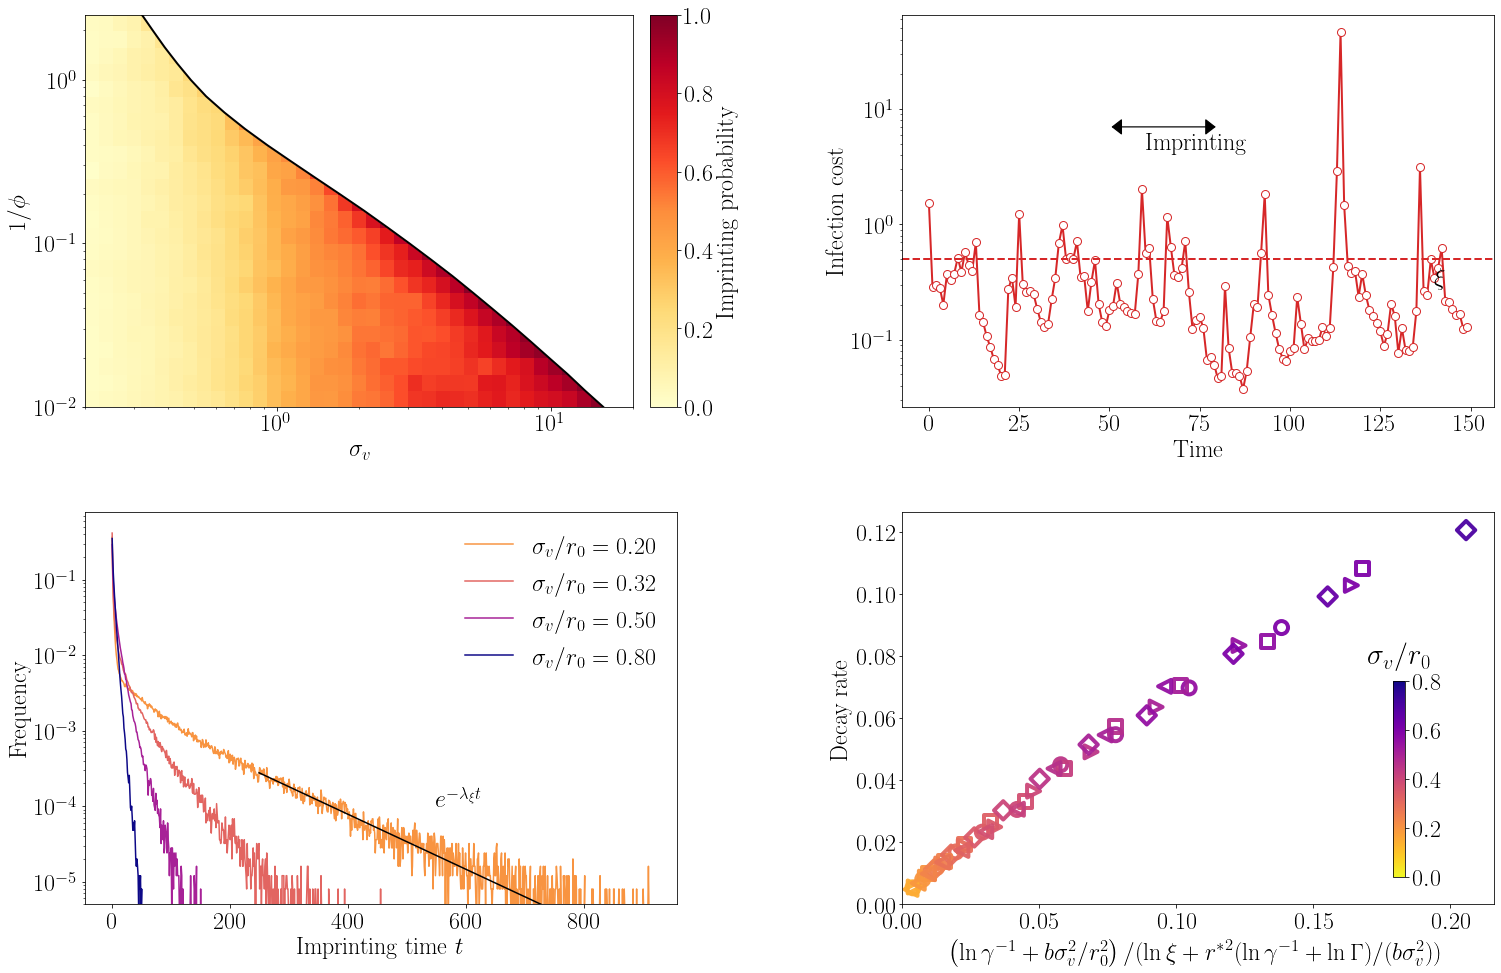

In [4]:
fig = plt.figure()

gs1 = fig.add_gridspec(nrows = 1, ncols = 2,
                       bottom = 0.57, top = 0.98,
                       wspace = 0.38)
                        
ax2 = fig.add_subplot(gs1[:, 0])
ax0 = fig.add_subplot(gs1[:, 1])
set_size(1.5*5.48, 1.2*4.54, ax0)

gs2 = fig.add_gridspec(nrows = 1, ncols = 2, wspace = 0.38,
                       bottom = 0.05, top = 0.46)
                        
ax1 = fig.add_subplot(gs2[:, 0])
ax4 = fig.add_subplot(gs2[:, 1])

(sigvar, jump_hists, 
 time_trace, xi_trace, sigv_trace) = load_data_imprinting()
nsigv = len(sigvar)

style = "<|-|>, head_length=9.0, head_width=7"
kw = dict(arrowstyle=style, color="k")

jump = mpatches.FancyArrowPatch((50, 7), 
                                (80, 7), linewidth = 1.2,
                                connectionstyle="arc3", zorder = 16, **kw)

ax0.add_artist(jump)
ax0.annotate(r'Imprinting', (60, 4.5))
ax0.annotate(r'$\xi$', (140, 0.3))

ax0.plot(time_trace[400:550],'o-', linewidth = 2, color = 'C3',
         markersize = 8, markerfacecolor = 'w')
ax0.axhline(y = xi_trace, color = 'C3', 
            linestyle = '--', linewidth = 2)

ax0.set_yscale('log')
ax0.set_xlabel('Time')
ax0.set_ylabel('Infection cost')


(q, params, sigvar_a, dim, xiar,
 rhos, alphas) = load_data_maturation()

cmap_sigv = sns.color_palette("plasma_r", as_cmap = True)
norm = mpl.colors.Normalize(vmin  = 0, 
                            vmax = max(np.max(sigvar.flatten()),
                                       np.max(sigvar.flatten())))


for k in range(nsigv):
    
    hist, center = jump_hists[k]
    sigv = sigvar[k]
    ax1.plot(center, hist, '-', linewidth = 1.5, label = r'$\sigma_v/r_0 = %.2f$' % (sigv),
             color = cmap_sigv(norm(sigv)))

ax1.set_yscale('log')
ax1.set_xlabel(r'Imprinting time $t$')
ax1.set_ylabel('Frequency')
ax1.legend(frameon = False)


def func(x, a, b):
    return np.exp(-a*(x - b))

xmin = 250
hist, center = jump_hists[0]
ccdf = np.cumsum(hist[::-1])[::-1]
p, pcov = curve_fit(func, center[xmin:], hist[xmin:], p0 = [0.01, 1])
xexp = np.linspace(xmin, 900)
ax1.plot(xexp, np.exp(-p[0]*(xexp - p[1])), 'k-')
ax1.set_ylim(ymin = 5e-6)
ax1.annotate(r'$e^{-\lambda_\xi t}$', (550, 1e-4))
nparams = len(params[:,0])

Gamma = params[:,1]*(1 + params[:,0])
r_star = np.log(params[:,0]*params[:,1]/(1 - params[:,1]))**(1/q)
u = 1 - np.log(Gamma)/np.log(params[:,1])


markers = ['o', 's', '>', 'D', '<', '^']

axins = inset_axes(ax4,
                    width="2%",
                    height="50%",
                    loc = 'lower right',
                    bbox_to_anchor =  (-0.13, 0.04, 1., 1.),
                    bbox_transform = ax4.transAxes)

axins.set_title(r'$\sigma_v/r_0$', pad = 18)


def func(x, a):
    return a*x
    
slopes = np.zeros(nparams)
for j in range(nparams):
    
    sigvar = sigvar_a[j,:]
    slope, _ = curve_fit(func, (sigvar[0:-1]/r_star[j])**2/u[j], alphas[j,0:-1])
    slopes[j] = slope

slope = np.mean(slopes)

for j in range(nparams):

    sigv = sigvar_a[j,:]
    #u[j]*(r_star[j]/sigv)**2/slope
    scaling = (np.log(xiar[:,j])/np.log(1/params[j,1]) + u[j]*(r_star[j]/sigv)**2/slope)/(1.0 - slope*sigv**2/np.log(params[j,1]))
    a = ax4.scatter(1/scaling,
                   rhos[j,:], s = 13**2, c = sigv, cmap = cmap_sigv,
                   marker = markers[j], alpha = 0.95, lw = 4, norm = norm)
    
    a.set_facecolor('none')
    #ax4.plot((sigv/r_star[j])**2/u[j], 0.4*(sigv/1)**2, 'k-')
#\frac{{r^*}^2 ( 1 - \ln \Gamma/\ln\gamma)}{p\sigma_v^2}
ax4.set_xlabel(r'$\left( \ln \gamma^{-1} + b \sigma_v^2/r_0^2 \right)/(\ln \xi + {r^*}^2 ( \ln \gamma^{-1} + \ln \Gamma)/(b\sigma_v^2))$')
ax4.set_ylabel(r'Decay rate')
ax4.set_xlim(xmin = 0)
ax4.set_ylim(ymin = 0)


cb1 = mpl.colorbar.ColorbarBase(axins, cmap = cmap_sigv,
                                norm = norm,
                                orientation = 'vertical')



(sigvar, mvar, numar, 
 params, sigvPCN) = load_map_data()

color_map = sns.color_palette("YlOrRd", as_cmap=True)
norm = mpl.colors.Normalize(vmin  = 0, vmax = 1.0)

mvar[numar == 0] = np.nan
c = ax2.pcolormesh(sigvar, params, mvar[:,:].T, cmap = color_map, norm = norm,
                   linewidth = 0,  shading = 'flat')
ax2.plot(sigvPCN, params, 'k-', linewidth = 2)
ax2.fill_betweenx(params, sigvPCN, 20, color='white')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", "5%", pad="3%")
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = color_map), cax = cax, ax = ax2)
cbar.set_label(r'Imprinting probability')

ax2.set_xlabel(r'$\sigma_{v}$')
ax2.set_ylabel(r'$1/\phi$')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.subplots_adjust(wspace = 0.4)
plt.show() 

'''
cax = divider.append_axes("top", "5%", pad="3%")
cbar = fig.colorbar(c, cax = cax, ax = ax2, orientation = 'horizontal')
cbar.set_label(r'Probability to move')

cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
'''

save_fig(fig, 'fig5')

In [19]:
print(sigv_trace)

0.5039684199579493
